In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import IPython.display

In [3]:
sys.path.insert(0, "/home/zkhan/source/ALBEF")

In [4]:
import matplotlib.pyplot as plt
import skimage.io
from matplotlib.patches import Polygon
import cv2
import random
import colorsys
import os
from torch import nn
from skimage.measure import find_contours

In [5]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor, resize
from PIL import Image, ImageDraw, ImageFont
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
from models.tokenization_bert import BertTokenizer
from models.singlestream_v2.baseline_mim_pseudolabel import ALBEF
from models.vit import interpolate_pos_embed

In [7]:
import json
import random
import ruamel.yaml as yaml

In [8]:
from dataset.utils import pre_caption

In [9]:
with open('/net/acadia10a/data/zkhan/coco2017/pretrain-pairs.json', 'r') as f:
    coco = json.load(f)
    
with open('/net/acadia10a/data/zkhan/cc3m/cc3m-train-pairs.json') as f:
    cc3m = json.load(f)

In [10]:
IMAGE_RES = 512

In [11]:
normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
test_transform = transforms.Compose([
        transforms.Resize((IMAGE_RES,IMAGE_RES),interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        normalize,
])

view_transform = transforms.Compose([
        transforms.Resize((IMAGE_RES, IMAGE_RES),interpolation=Image.BICUBIC),
        transforms.ToTensor(),
])



with open('../configs/ablations/Pretrain4M_SharedTxtEncoder.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.Loader)
# patch the BERT config to be an absolute path because we're running
# the code from a different directory
config['bert_config'] = '/home/zkhan/source/ALBEF/configs/shared_bert.json'
config['image_res'] = IMAGE_RES

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = ALBEF(config=config, text_encoder='bert-base-uncased', tokenizer=tokenizer, init_deit=True)
checkpoint = torch.load(
    '/net/acadia10a/data/zkhan/ALBEF-checkpoints/ablations/shared_txt_enc_pseudolabels_multimodal_mim_momentum/checkpoint_29.pth',
    #'/net/acadia10a/data/zkhan/ALBEF-checkpoints/ablations/shared_txt_enc_with_momentum_multimodal_mim/checkpoint_10.pth',
    # '/net/acadia10a/data/zkhan/ALBEF-checkpoints/pretrain-4m/checkpoint_29.pth',
    #/net/acadia10a/data/zkhan/ALBEF-checkpoints/downstream/shared_txt_enc_pseudolabels_multimodal_mim_momentum/refcoco_epoch30/checkpoint_best.pth',
    map_location='cpu'
)
state_dict = checkpoint['model']
for key in list(state_dict.keys()):
    if 'bert' in key:
        encoder_key = key.replace('bert.','')         
        state_dict[encoder_key] = state_dict[key] 
        del state_dict[key]    
pos_embed_reshaped = interpolate_pos_embed(
    state_dict['visual_encoder.pos_embed'], model.visual_encoder
)         
state_dict['visual_encoder.pos_embed'] = pos_embed_reshaped
m_pos_embed_reshaped = interpolate_pos_embed(state_dict['visual_encoder_m.pos_embed'],model.visual_encoder_m)   
state_dict['visual_encoder_m.pos_embed'] = m_pos_embed_reshaped 
msg = model.load_state_dict(state_dict,strict=False) 

device = torch.device('cuda:7')
model.eval();
mode = model.to(device)

/home/zkhan/miniconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


reshape position embedding from 196 to 1024
missing_keys=['mask_token']	unexpected_keys=['head.weight', 'head.bias']


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.embeddings.token_type_embeddings.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.7.crossattention.output.dense.bias', 'bert.encoder.layer.6.crossattention.self.value.weight', 'bert.encoder.layer.7.crossattention.output.LayerNorm.weight', 'bert.encoder.

Some weights of BertForMaskedLM were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.7.crossattention.output.dense.bias', 'bert.encoder.layer.6.crossattention.self.value.weight', 'bert.encoder.layer.7.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.3.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.11.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.7.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.5.crossattention.self.key.bias', 'bert.encoder.layer.9.crossattention.self.value.weight', 'bert.encoder.layer.5.crossattention.self.key.weight', 'bert.encoder.layer.9.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.10.crossattention.self.value.weight', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.2.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.de

reshape position embedding from 256 to 1024
reshape position embedding from 256 to 1024


2487262
at one of the food stalls


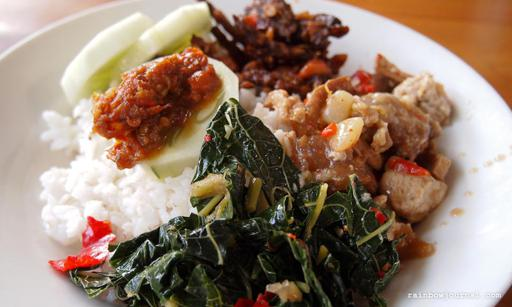

In [557]:
sample_idx = random.choice(range(len(cc3m)))
print(sample_idx)
#sample = coco[sample_idx]
sample = cc3m[sample_idx]
print(sample['caption'])
IPython.display.Image(sample['image'], width=300)

In [558]:
image = test_transform(Image.open(sample['image']).convert('RGB'))
view_image = view_transform(Image.open(sample['image']).convert('RGB'))

([], [])

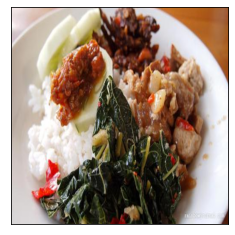

In [559]:
plt.imshow(view_image.permute(1, 2, 0))
plt.xticks([])
plt.yticks([])

In [560]:
caption = pre_caption(sample['caption'], 30)
caption

'at one of the food stalls'

In [561]:
image = image.to(device)

In [562]:
text = tokenizer(caption, padding='longest', truncation=True, max_length=25, return_tensors="pt").to(device)

In [563]:
with torch.no_grad():
    image_embeds = model.visual_encoder(image.unsqueeze(0))
    image_embeds.shape
image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)

In [564]:
with torch.no_grad():
    t2i_output = model.text_encoder_m.bert(
                text.input_ids, 
                attention_mask = text.attention_mask,
                encoder_hidden_states = image_embeds,
                encoder_attention_mask = image_atts,      
                return_dict = True,
                mode = 'multimodal',
                output_attentions=True
    )
    
with torch.no_grad():
    image_embeds_m = model.visual_encoder_m(image.unsqueeze(0)) 
    image_feat_m = F.normalize(model.vision_proj_m(image_embeds_m[:,0,:]),dim=-1)  

In [565]:
seq_length = text.input_ids.shape[-1]
batch_size = text.input_ids.shape[0]
encoder_layer_idx = 11
t2i_self_attention = t2i_output.attentions
num_concepts_per_head = 4
most_salient_positions_per_batch_element = t2i_self_attention[encoder_layer_idx][:,:, 0]\
                .view(-1, seq_length)\
                .topk(num_concepts_per_head, dim=-1)\
                .indices.view(batch_size, -1)
counts_per_position = torch.zeros(
                most_salient_positions_per_batch_element.shape[0],
                seq_length,
                dtype=most_salient_positions_per_batch_element.dtype,
                device=most_salient_positions_per_batch_element.device
            )
dummy_for_scatter_add = torch.ones_like(most_salient_positions_per_batch_element)\
                .to(most_salient_positions_per_batch_element.device)
counts_per_position.scatter_add_(
                1, 
                most_salient_positions_per_batch_element, 
                dummy_for_scatter_add
            )
most_salient_tokens = torch.gather(text.input_ids, 1, counts_per_position.topk(5, dim=-1).indices)
concept_hard_targets = torch.zeros(batch_size, tokenizer.vocab_size, device=image.device)
concept_hard_targets.scatter_(1, most_salient_tokens, 1)

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:7')

In [566]:
concept_soft_targets = torch.sigmoid(model.concept_head_m(image_feat_m))
most_salient_soft_targets = concept_soft_targets.topk(40)

In [567]:
for token in most_salient_tokens.cpu():
    print(tokenizer.decode(token))
for token in most_salient_soft_targets.indices.cpu():
    print(tokenizer.decode(token))

[CLS] at food stalls one
the a in green on red of with and tree white building is wall this water an person tower woman dog by flag from orange artist to sky boat river snow bridge flower walking house girl trees for at old
